<a href="https://colab.research.google.com/github/JoHandzz/AOC-2023/blob/main/EM3_2026_ERP_and_multivariate_analyses_(student_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DEMO: ERP, statistics, and multivariate analyses

Dataset description

The current data corresponds to an auditory mismatch negativity (MMN) experiment investigating the neural responses to unexpected sounds. It was recorded using the classical oddball paradigm in which a standard sound is repeated several times and is ocassionally interrupted by a deviant sound:

A A A A A A B A A A A B A A A ....

The participant listened to the sounds passively. These data belong to a collection of EEG datasets comprising some well-known event-related potentials (ERPs) used to study key cogntive functions. For more information, see:

    Kappenman, E. S., Farrens, J. L., Zhang, W., Stewart, A. X., & Luck, S. J. (2021). ERP CORE: An open resource for human event-related potential research. NeuroImage, 225, 117465. https://doi.org/10.1016/j.neuroimage.2020.117465

The goal of this analysis is to identify the differences in neural activity between expected and surprising sounds. These sounds are marked as different events in the EEG recording with the following codes:

    standard: 80
    deviant: 70

Below you will be asked to solve a series of excercises by completing the code marked with ...

For the analyses we will use the MNE-Python library.

https://mne.tools/stable/index.html

You can search each of the functions mentioned below in the documentation of the toolbox:

https://mne.tools/stable/api/python_reference.html

It is highly recommended not to use chatbots for this excercise. Just use your brain and the documentation above.

Have fun!

#1. Initial setup

First, we need to install and load the relevant Python packages as well as download the data from the web. Just run the following snippets of code by pressing the "play" icon on the left. This part will take a couple of minutes.

In [1]:
!pip install mne==1.8.0 # installing the MNE toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.3 MB/s eta 0:00:00


Load the libraries and setup plotting parameters


In [2]:
import numpy as np
import pickle
import mne
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
# set size of raw browser
mne.utils.config.set_config('MNE_BROWSE_RAW_SIZE','16.0,8.0')

Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


These are some helper functions to browse raw data (just run the cell below)

In [3]:
#@title
def inspect_raw(craw,start, chan_sel,nchan=10,time_step=2,events=None):
    order = np.arange(nchan, dtype = int) + int(nchan*(chan_sel-1))
    order = order[order < len(raw.ch_names)]
    cfig = craw.plot(events = events, start = start, duration = time_step,
                     order = order,show_scrollbars = False)

def raw_interact(craw, time_step = 2, nchan = 10, events=None):
    _ = widgets.interact(inspect_raw,
                     craw = widgets.fixed(craw),
                     nchan = widgets.fixed(nchan),
                     time_step = widgets.fixed(time_step),
                     events = widgets.fixed(events),
                     start = widgets.FloatSlider(value = 0,min = 0,max = raw.times[-1], step = time_step, description = 'time'),
                     chan_sel = widgets.FloatSlider(value = 1, min = 1,step = 1, max = int(np.ceil(len(raw.ch_names)/nchan)),description = 'chan group'))


Now we can download the dataset

In [4]:
#!wget -O data.zip https://files.osf.io/v1/resources/5q4xs/providers/osfstorage/5f24a53fb084f6011ac9d604/?zip=
!wget -O data.zip https://www.dropbox.com/scl/fo/z3xf96y5fk0t3z5sacvo7/ABslujmuCctLvYqQgLgDZK0?rlkey=abn3wwjmpp1oqc0n26b5ytq5z&dl=0

--2026-02-17 10:00:38--  https://www.dropbox.com/scl/fo/z3xf96y5fk0t3z5sacvo7/ABslujmuCctLvYqQgLgDZK0?rlkey=abn3wwjmpp1oqc0n26b5ytq5z
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2994fcde6507cfba5defc6bb2.dl.dropboxusercontent.com/zip_download_get/CecgcTiOhtuxdiX3qiJdL1b7_KdHhsY-pUWRJ8mDn6gXdtwpUet0YRskJPOZh102tqOAwuJmYiRN2OyBh_SOq9G07gdMle1RRrixalvrTcHVeA# [following]
--2026-02-17 10:00:39--  https://uce2994fcde6507cfba5defc6bb2.dl.dropboxusercontent.com/zip_download_get/CecgcTiOhtuxdiX3qiJdL1b7_KdHhsY-pUWRJ8mDn6gXdtwpUet0YRskJPOZh102tqOAwuJmYiRN2OyBh_SOq9G07gdMle1RRrixalvrTcHVeA
Resolving uce2994fcde6507cfba5defc6bb2.dl.dropboxusercontent.com (uce2994fcde6507cfba5defc6bb2.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uce2994fcde6507cfba5defc6bb2.dl.dropbo

And exctract the files

In [5]:
!unzip data.zip
!rm data.zip
os.listdir(os.getcwd()) # verify that all files have been downloaded

Archive:  data.zip
mapname:  conversion of  failed
   creating: graphs/
 extracting: 10_MMN.set              
 extracting: 10_MMN.fdt              
 extracting: graphs/10_MMN_ICA_Weights.pdf  
 extracting: 10_MMN_ds_reref_ucbip_hpfilt_ica_weighted.set  
 extracting: 10_MMN_ds_reref_ucbip_hpfilt_ica_weighted.fdt  


['.config',
 '10_MMN.fdt',
 '10_MMN_ds_reref_ucbip_hpfilt_ica_weighted.fdt',
 'graphs',
 '10_MMN.set',
 '10_MMN_ds_reref_ucbip_hpfilt_ica_weighted.set',
 'sample_data']

#2. Loading and inspecting the data

Reading /content/10_MMN.fdt
Reading 0 ... 628735  =      0.000 ...   613.999 secs...


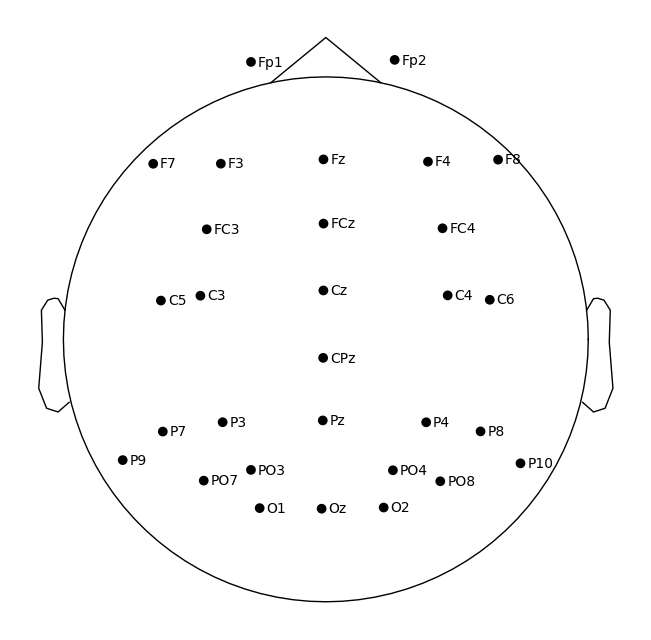

In [6]:
### Loading and setting up the raw data
raw = mne.io.read_raw_eeglab('10_MMN.set', preload = True) # load the raw data

# Some EOG channels were recorded to track eye movements. Here we label them:
raw.set_channel_types({ch: 'eog' for ch in raw.ch_names if 'EOG' in ch})

# Now we assign spatial electrode coordinates according to the 1020 system:
raw.rename_channels({'FP1': 'Fp1','FP2': 'Fp2'}) # rename to coincide with 1020 system
raw = raw.set_montage('standard_1020') # set the electrode positions (or montage)

fig = raw.get_montage().plot()

In [7]:
print(f"Number of channels: {len(raw.ch_names)}")
print(f"Sampling rate: {raw.info['sfreq']}")
print(f"Channel names: {raw.ch_names}")
print(f"Data shape: {raw.get_data().shape}")

Number of channels: 33
Sampling rate: 1024.0
Channel names: ['Fp1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'Fp2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'HEOG_left', 'HEOG_right', 'VEOG_lower']
Data shape: (33, 628736)


Let's do some preprocessing.

Often we record data at high temporal resolution. To make our analyses more efficient, we often reduce the sampling rate as shown below. Besides, we filter the data to get rid of slow drifts, high-frequency noise and power-line artifacts.


In [8]:
raw = raw.resample(256) # Resample
raw = raw.notch_filter(60) # Filter power line noise (60 Hz in the US, 50 Hz in Europe)
raw = raw.filter(l_freq = 1, h_freq = 40)
print(raw.info)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FC3, C3, C5, P3, P7, P9, PO7, PO3, O1, Oz, Pz, CPz, ...
 chs: 30 EEG, 3 EOG
 custom_ref_applied: False
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 256.0 Hz
>


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


Now we can use Independent Component Analysis (ICA) to to identify components in the data corresponding to eye movements.

ICA finds components that are completely independent from each other, which allows them to capture meaningful patterns making them more interpretable.

ICA has become the gold standard for the correction of EOG artifacts. In MNE,
ICA can be easily implemented as shown below (this takes some time).

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Fitting ICA took 14.1s.


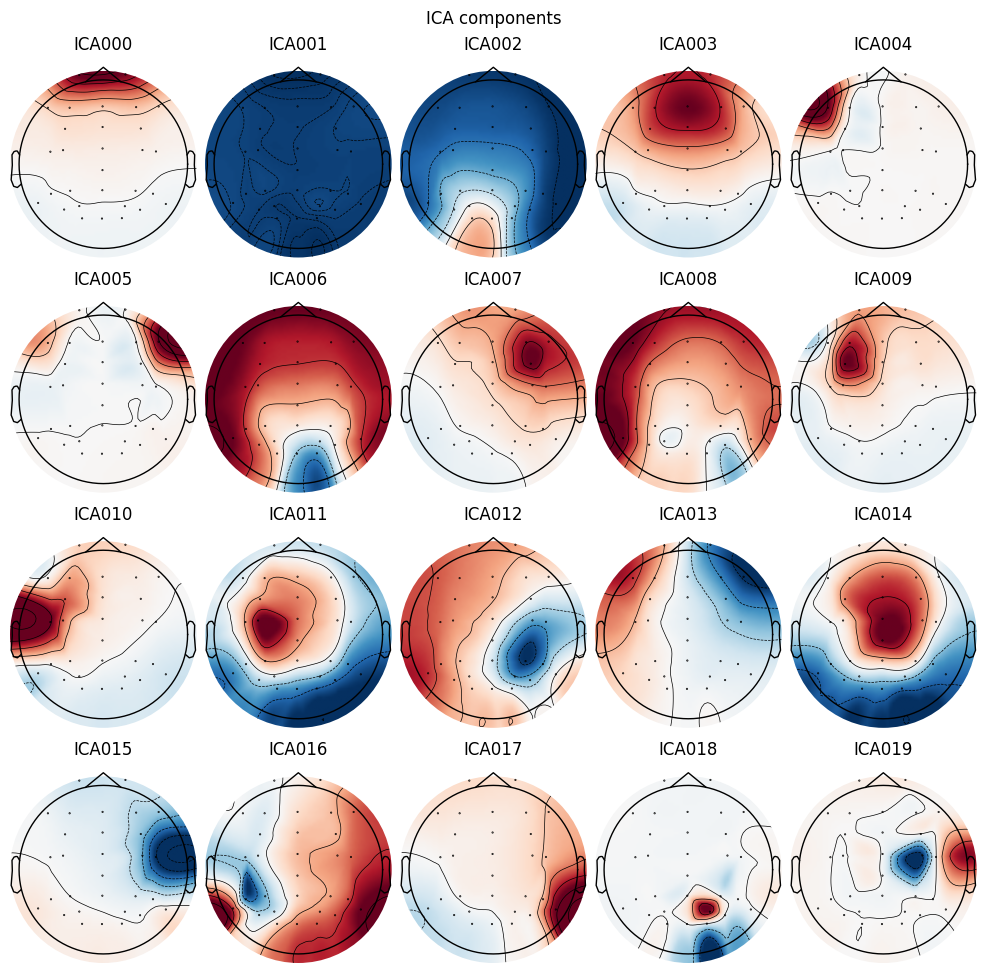

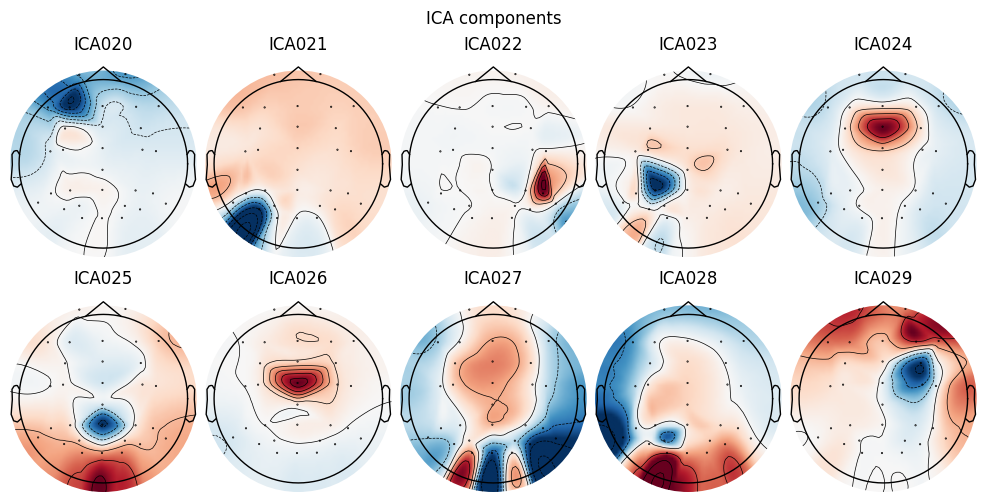

Creating RawArray with float64 data, n_channels=33, n_times=157184
    Range : 0 ... 157183 =      0.000 ...   613.996 secs
Ready.
Using matplotlib as 2D backend.


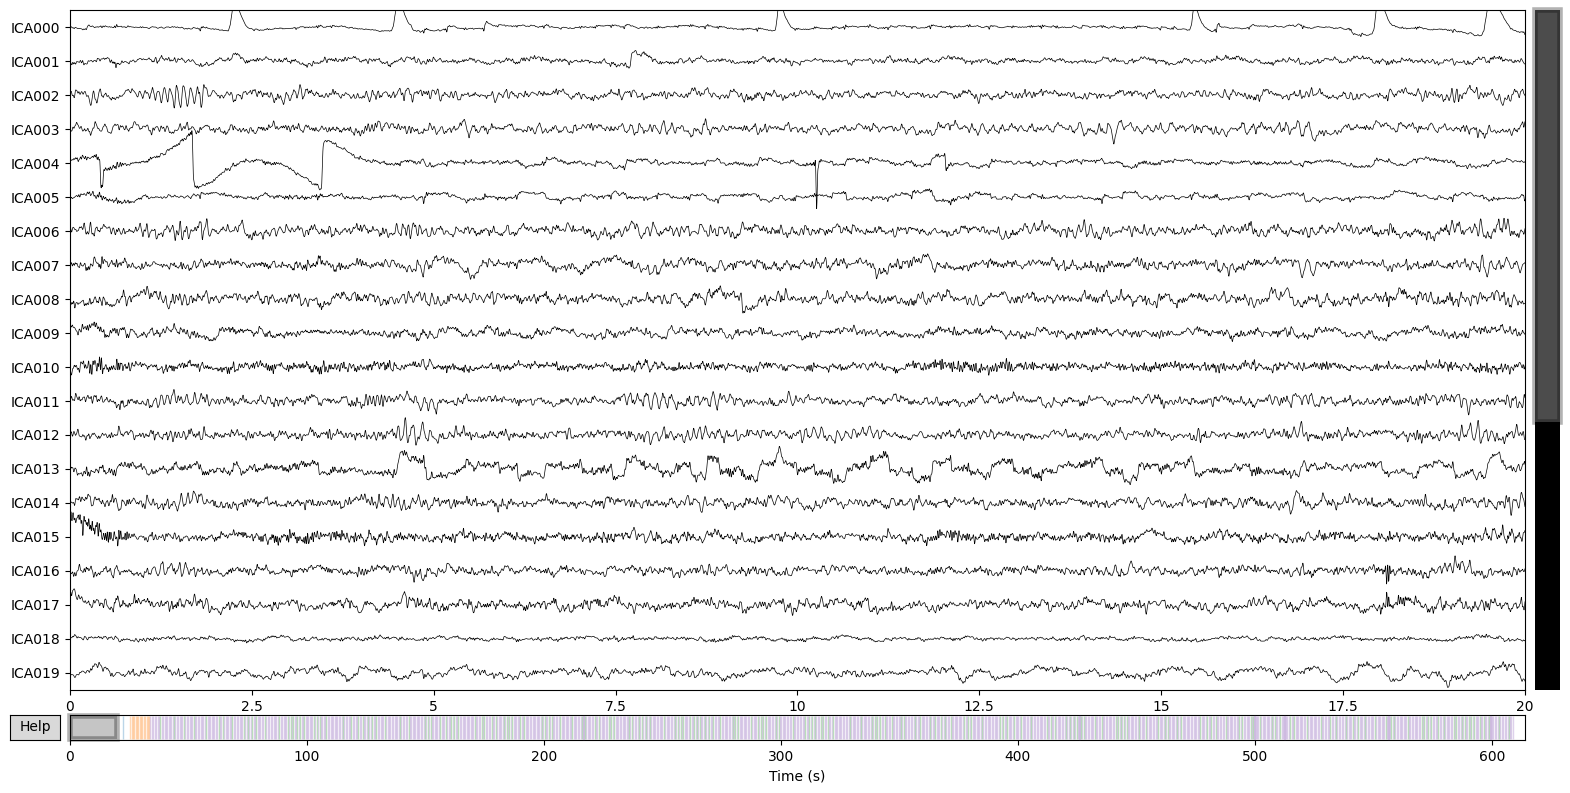

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components


In [9]:
ica = mne.preprocessing.ICA(random_state=42)
ica.fit(raw.copy().pick('eeg'))
ica.plot_components()
ica.plot_sources(raw)
raw_ica = ica.apply(raw.copy(),exclude= [0,4,5,13])

Now we can have a look at the data, using the interactive function.
We can control how long a segment and how many channels to display at once. Use the sliders to move around. What do you see?

In [10]:
raw_interact(raw,time_step=2,nchan=20)

interactive(children=(FloatSlider(value=0.0, description='time', max=613.99609375, step=2.0), FloatSlider(valu…

# Exercise 2.1 - Finding events of interest
To be able to make comparisons of interest, we mark the times when interesting things happen. These times are called "events". In MNE, these events are represented in a N x 3 ndarray, with N events and event onset, duration and code represented in the first, second and third colum.

In addition, we have an event_id dictionary indicating the mapping between our event names and their respective numeric codes.

In this dataset, events are stored as 'annotations'. We need to retrieve them using the mne.events_from_annoations() function.

* Print your array of events. What is the shape (or dimensions) of this array?
* The first column of the array represents time stamps. What are its units?
* How can we tell, in seconds, when an event happened? (Hint: use raw_ica.info['sfreq'])
* What do the codes in column 3 represent? (Hint: look at the event_id dictionary)

In [16]:
events, event_id = mne.events_from_annotations(raw_ica)

# Event array
for i, e in enumerate(events):
  if i > 10:
    break
  print(e)

# Shape of array
print(events.shape)

# Timestamps in seconds
seconds = raw_ica.info['sfreq']
print(seconds)

# Identity of events
print(...)

Used Annotations descriptions: [np.str_('1'), np.str_('180'), np.str_('70'), np.str_('80')]
[5736    0    1]
[6512    0    2]
[6652    0    2]
[6800    0    2]
[6941    0    2]
[7078    0    2]
[7230    0    2]
[7368    0    2]
[7520    0    2]
[7683    0    2]
[7824    0    2]
(1001, 3)
256.0
Ellipsis


Now we plot the data again with our events of interest marked.



In [17]:
raw_interact(raw_ica,nchan=20,events=events)

interactive(children=(FloatSlider(value=0.0, description='time', max=613.99609375, step=2.0), FloatSlider(valu…

# 3. Event Related Potential (ERP) analyses



One of the standard techniques in EEG research is to study the activity evoked by specific stimuli. We typically find the events of interest and average their waveforms. We call these responses Event Related Potentials or ERPs. Afterwards, we can compare the activity evoked by different stimuli or in different conditions to make inferences about cognitive processes.

# Exercise 3.1. Re-referencing

Before looking further, we typically set a new reference for our EEG recordings. A popular choice is to take the average of all channels as reference.

* Use the raw_ica.set_eeg_reference() method to set the reference to a channel (e.g., PO7) and plot the data. How did the signal change?
* Use the same method to set the reference to "average". How did the signal change?

In [18]:
# We can change our referencing scheme
raw_ref = raw_ica.set_eeg_reference(ref_channels='average')
raw_interact(raw_ref, nchan=20)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


interactive(children=(FloatSlider(value=0.0, description='time', max=613.99609375, step=2.0), FloatSlider(valu…

# Excercise 3.2. Epoching
Now we need to cut our data into small pieces locked to the stimuli we are interested in. We cut epochs from -100 ms to 600 ms around stimulus onset.

In addition, we will subtract from each epoch the mean activity during a baseline period between -100 ms and 0 ms. This is called "baseline correction" and allows us to reduce the impact of slow drifts in the data.

Using the mne.Epochs function, obtain an Epochs class with data of the shape nevents x nchannels x ntimes

In [22]:
# Chunk the data into epochs
tmin = -.2
tmax = .6
baseline = (-.1,0)
epochs = mne.Epochs(raw_ica, preload=True, tmin = tmin, tmax=tmax, baseline=baseline)



Used Annotations descriptions: [np.str_('1'), np.str_('180'), np.str_('70'), np.str_('80')]
Not setting metadata
1001 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1001 events and 206 original time points ...
0 bad epochs dropped


What is the shape of the epochs data?
How many timepoints are there?
How many trials were averaged per condition?

Hint: look at the attributes of the mne.Epochs class: https://mne.tools/stable/generated/mne.Epochs.html

In [29]:
# Inspect the epochs
print(epochs.info)
print(epochs.get_data().shape)
print(epochs.event_id)

(1001, 33, 206)
{np.str_('1'): 1, np.str_('180'): 2, np.str_('70'): 3, np.str_('80'): 4}


After getting the epochs, we can now average the different conditions and store them in a dictionary. This is what we call an evoked response. Complete the code below to do that. Hint: use the epochs.average() method. You can index the condition of interest like this: epochs['70'].average().

In [44]:
ERPs = {str(e): epochs[str(e)].average() for e in event_id}

Let's now inspect our two conditions. We will plot the EEG topographies at different times in the trial. When do interesting things happen? What differences do you see between standard and deviants?

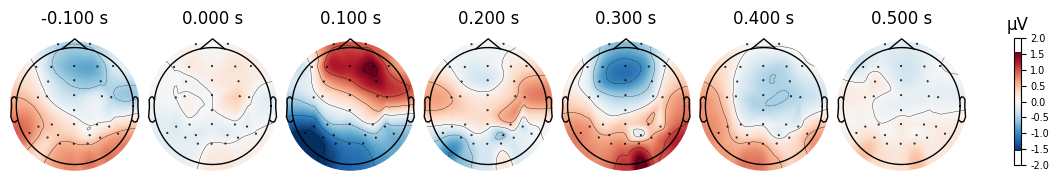

In [45]:
#Standard sounds
fig = ERPs['80'].plot_topomap(times=np.arange(-.1,.6,.1),show=False)

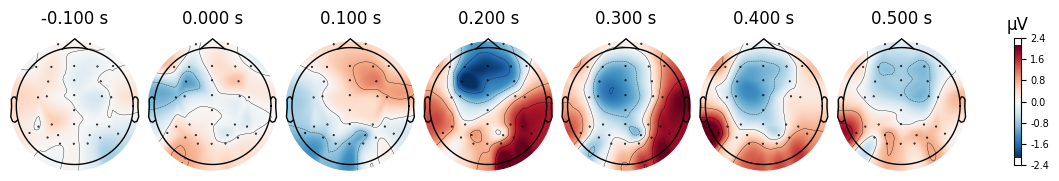

In [46]:
# Deviant sounds
fig = ERPs['70'].plot_topomap(times=np.arange(-.1,.6,.1),show=False)

Now let's plot the ERP for a specific channel. For auditory MMN responses, we usually look at electrode Fz.

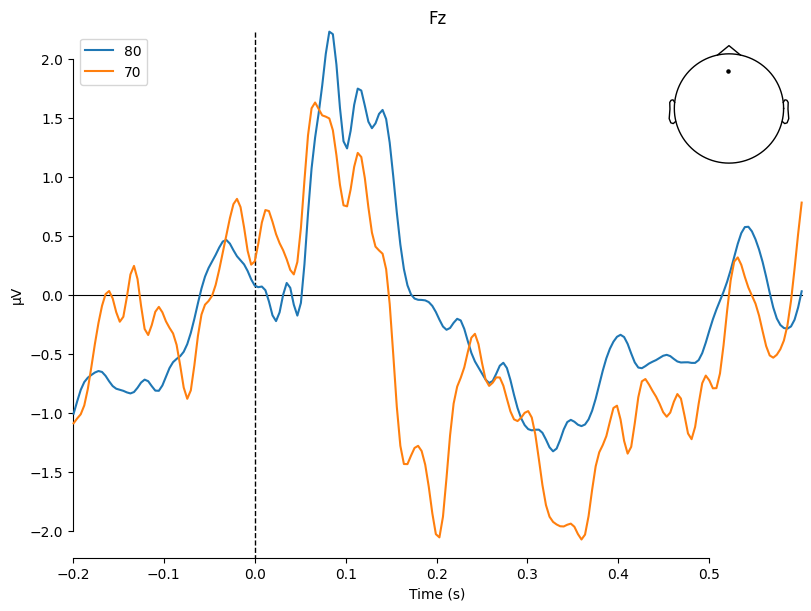

[<Figure size 800x600 with 2 Axes>]

In [47]:
mne.viz.plot_compare_evokeds([ERPs['80'],ERPs['70']],picks=['Fz'])

The MMN is calculated as the difference between standard and deviants. We do that here:

In [50]:
ERPs['difference'] = mne.combine_evoked([ERPs['70'],ERPs['80']], weights=[1,-1])
ERPs['difference'].comment = 'difference'

# print(ERPs['difference'])

# Excercise 3.3.

Use the plot_compare_evokeds method to plot the MMN time course for electrode Fz

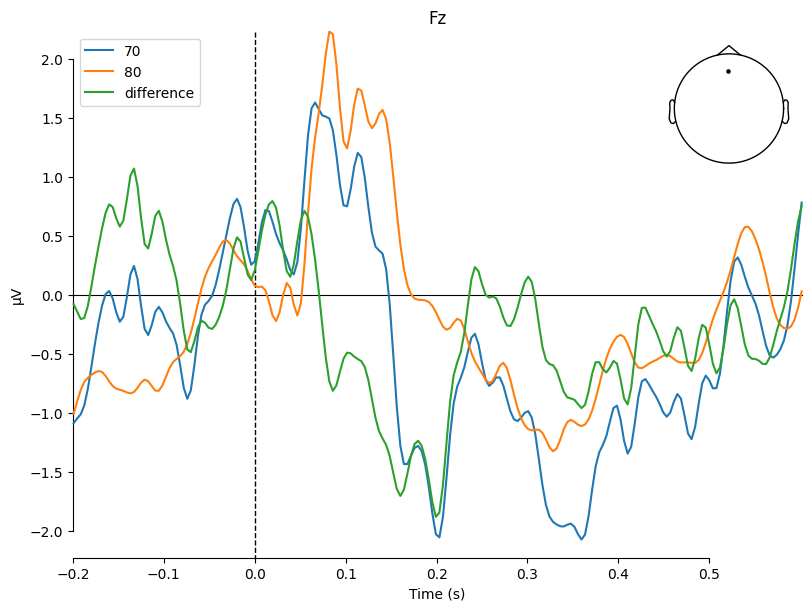

In [51]:
fig = mne.viz.plot_compare_evokeds([ERPs['70'], ERPs['80'], ERPs['difference']], picks='Fz')

Use the plot_topomap method to plot the scalp topographies of the MMN:

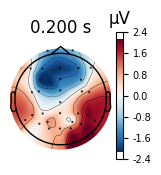

In [58]:
fig = ERPs['70'].plot_topomap(times=0.200)

Let's explore another way of plotting:

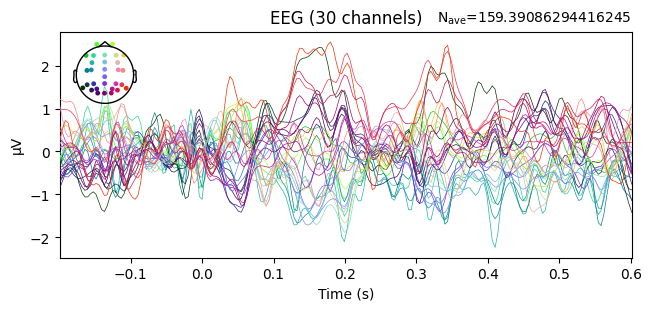

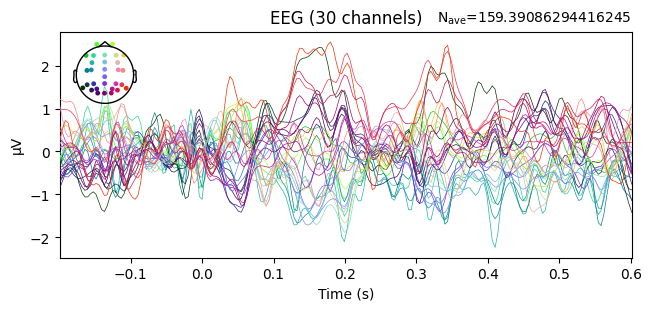

In [55]:
ERPs['difference'].plot()

# Excercise 3.4. (optional)

Now let's compare it with a different reference scheme. Can you re-reference the epochs to channels ['P9','P10'] and plot the averages?

In [ ]:
epochs2 = epochs.copy().set_eeg_reference(...)
ERPs2 = {str(e): epochs2[e].average() for e in event_id}
ERPs2['difference'] = ...
ERPs2['difference'].comment = 'difference'


In [ ]:
# Plot the averages below and compare with previous reference
fig = ERPs['difference'].plot_topomap(times=np.arange(-.1,.6,.1),show=False)
fig = ...


# 4. Basic statistics

For serious science, we cannot just trust our eyes. We need to also assess whether condition differences are statistically robust.

EEG data is multidimensional. This makes statistical analysis difficult. Should we run a t-test for every single EEG channel and timepoint?

Yes, but with caution. When we run so many tests on the same dataset, we are almost guaranteed to get a significant result for at least one time point and channel. Should we claim then that we made a discovery at 200 ms in channel 4?
Not really. Most likely, this effect is simply due to random variation in the data. For more details on this, look at:

* Luck, S.J. and Gaspelin, N. (2017), How to get statistically significant effects in any ERP experiment (and why you shouldn't). Psychophysiol, 54: 146-157. https://doi.org/10.1111/psyp.12639

To avoid that, we need to handle the multiple comparison problem. There are many ways to do that. Here we will explore the simplest.



# Exercise 4.1.

Use the ttest_ind() function from the scipy library to run a t-test comparing standard sounds ('80') vs deviant sounds ('70') at each EEG channel and time point. You can look at the documentation of this function here:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Hint: To get the data for each condition you can use the epochs.get_data() method. For example: epochs['70'].get_data()

In [67]:
# We can do a t-test between conditions to find their differences
from scipy.stats import ttest_ind

tvals, pvals = ttest_ind(epochs['80'].get_data(), epochs['70'].get_data())
print(pvals.shape)


(33, 206)


Now let's find the channels and timepoints where differences were significant.

In [71]:
pmask = pvals <= .05
print(pmask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


We can plot the topographies with the statstically significant time-points and channels by passing our pmask to the mask parameter of the function:

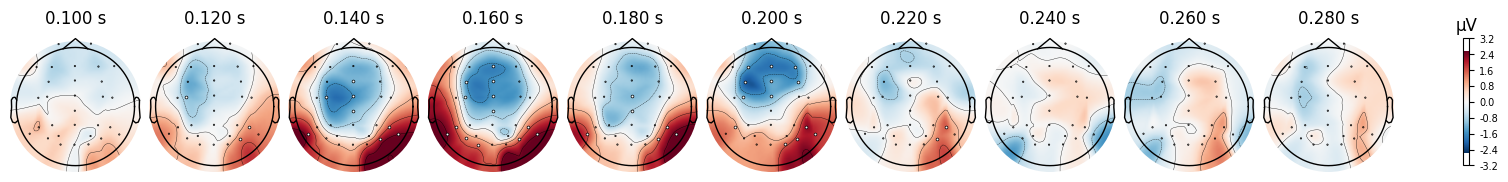

In [72]:
# Plot p-values
fig = ERPs['difference'].plot_topomap(times=np.arange(0.1,.3,.02),show=False, mask=pmask)

# Exercise 4.2.

So far, we have not corrected for multiple comparisons. This means some of our statistical differences might be false positives due to multiple testing.

We can correct for multiple comparisons with False Discovery Rate (FDR) correction, for example. Below we use the mne.stats.fdr_correction(pvals) with this purpose.

* Compute the mask of FDR-corrected significant timepoints (qvals) and plot it using the example from the previous cell.
* Did any of the significant points survive?
* Do you think this method is being too conservative (i.e., missing true effects that are actually real)?


In [74]:
_, qvals = mne.stats.fdr_correction(pvals)
qmask = qvals <= .05
print(qmask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


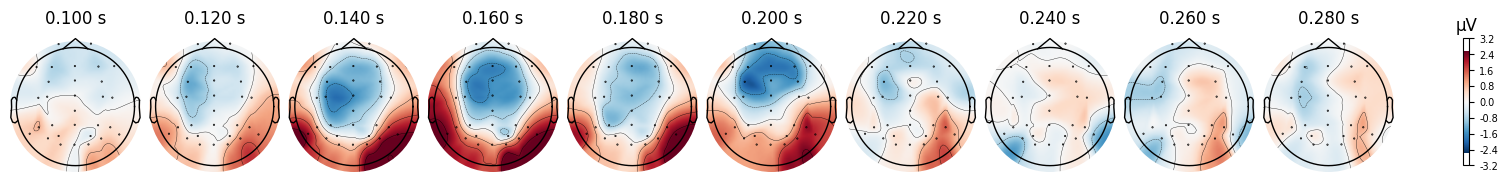

In [75]:
fig = ERPs['difference'].plot_topomap(times=np.arange(0.1,.3,.02),show=False, mask=qmask)

Sometimes, multiple comparison corrections will be too conservative. In that case you can use more principled ways to look at the effects that you are targetting. For example, you can average EEG activity for a specific time-window and channel chosen based on the literature and do statistic on these summary values. For the mismatch negativity, you can average from 150 to 250 ms of the electrode Fz.

We can do that below for one of our conditions.


In [76]:
time_index = (epochs.times >= 0.15) & (epochs.times <= 0.25) # Get time window
standard_means = epochs['80'].copy().pick('Fz').get_data()[:,:,time_index].mean(axis=-1)[:,0]
print(standard_means.shape)

(785,)


# Exercise 4.3.

Get mean amplitude values for the deviant sound ('70') and do a t-test using the ttest_ind function that you used before. Is there a significant difference between standard and deviant?






In [79]:
deviant_means = epochs['70'].get_data()
print(deviant_means.shape)

(200, 33, 206)


In [80]:
tval, pval = ttest_ind(deviant_means)
print(f't = {tval}, p = {pval}')

TypeError: ttest_ind() missing 1 required positional argument: 'b'

Finally, another approach that makes less assumptions about the data is cluster-based permutations:

https://mne.tools/stable/auto_tutorials/stats-sensor-space/50_cluster_between_time_freq.html

# 5. Multivariate Pattern Analysis, Machine learning and Decoding

Sometimes, EEG data can have rich patterns of activity across channels and time that are difficult to capture with conventional ERP analyses. To properly study them, we can use multivariate pattern analysis which employs machine learning techniques to discover how patterns of brain activity are related to stimuli and variables of interest.

One popular approach is to try to decode the identity of perceived stimuli from brain activity. Below, we will use this approach to predict whether the participant heard a standard ('80') or a deviant ('70') sound.

We will use logistic regression for this purpose, using the scikitlearn library. For details about this function, see here:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Moreover, MNE has an mne.decoding library with useful functions to handle multidimensional data such as EEG.

In particular, the SlidingEstimator allows us to fit and test a decoding model for each time point of the epochs.

First, we load the necessary libraries.


In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from mne.decoding import (
    LinearModel,
    Scaler,
    SlidingEstimator,
    cross_val_multiscore,
    get_coef)


Now we get our data.

* What are the dimension of the data matrix X?
* What are the dimesions of the class labels vector y?

In [89]:
X = epochs.copy().pick('eeg').get_data()[epochs.events[:,2]>2]  # EEG signals: n_epochs, n_channels, n_times
y = epochs.events[epochs.events[:,2]>2, 2]  # standard (4) vs deviant (3)

# We recode the deviants so that standard = 0 and deviant = 3
y = y*-1 + 4

# Now we get de dimensions
print(X.shape)
print(y.shape)

(985, 30, 206)
(985,)


Now we build our classification pipeline which consists of two steps:

1- Standardize the data by subtracting the mean and dividing by the standard deviation of each EEG channel (StandardScaler).

2- Fit the LogisticRegression.

At the end, we evaluate our model using 5-fold cross-validation (cross_val_multiscore)

In [90]:
# Now we make a classifier:
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression(solver="liblinear")))
decoder = SlidingEstimator(clf, n_jobs=-1, scoring="roc_auc", verbose=True)
scores = cross_val_multiscore(decoder, X, y, cv=KFold(n_splits=5,shuffle=True), n_jobs=None)

  0%|          | Fitting SlidingEstimator : 0/206 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/206 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/206 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/206 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/206 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.6s finished


We can plot the performance of the model at each time point below. When is the accuracy highest?

Text(0.5, 1.0, 'Sensor space decoding')

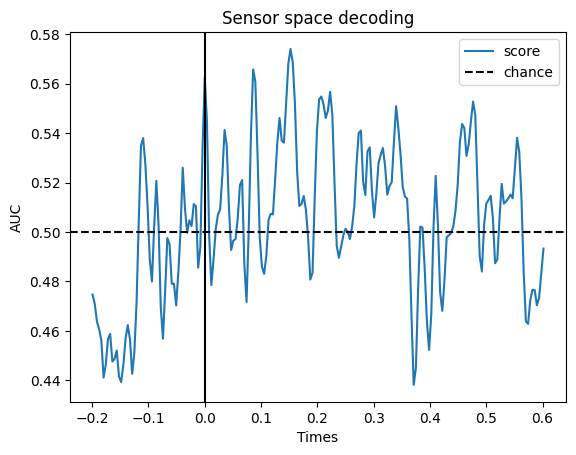

In [91]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores.mean(0), label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

 # Exercise 5.1.

 In decoding analyses, it is very important to never train and test your model with the same data. Otherwise, your model will overfit and give you a wrong impression of the true performance of the model.

* Just for fun, train and test the model on the same data and labels, and plot the accuracy using the same figure as before. How does the accuracy change? Hint: use the decoder.score() method.

In [ ]:
decoder.fit(X,y)
overfit = ...

In [ ]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores.mean(0), label="cross-validation score")
ax.plot(..., label="overfit score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

  # Bonus: Coefficient interpretation.

We can inspect the coefficients of our model to understand what patterns of activity distinguish one condition from another.

Note that model coefficients are not directly interpretable in terms of physiology. However, they can be transformed into patterns of activity as shown below.

See this paper for more info:

Stefan Haufe, Frank Meinecke, Kai Görgen, Sven Dähne, John-Dylan Haynes, Benjamin Blankertz, and Felix Bießmann. On the interpretation of weight vectors of linear models in multivariate neuroimaging. NeuroImage, 87:96–110, 2014. doi:10.1016/j.neuroimage.2013.10.067.

How to these patterns compare to the MMN difference wave that we calculated above?

In [ ]:
# Interpreting the coefficients:
decoder.fit(X,y)
patterns = get_coef(decoder,inverse_transform=True,attr='patterns_')

In [ ]:
evoked_time_gen = mne.EvokedArray(patterns, epochs.copy().pick('eeg').info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))
evoked_time_gen.plot_joint(
    times=np.arange(-.1,.6,.1),show=False, title="patterns"
)